# Interpretable Machine Learning: PD3

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import waterfall_chart

from xgboost import XGBClassifier

Przekopiowałem kod do wczytywania i transformacji danych oraz trenowania modelu z PD1.

In [35]:
path = r'D:\Interpretable Machine Learning\PD1\HCMST 2017 fresh sample for public sharing draft v1.1.dta'
data = pd.read_stata(path)

In [37]:
variables = ['ppage', 'w6_q24_length', 'w6_sex_frequency', 'w6_q23', 'w6_q27']
# Selecting variables
X = data[variables]
# Filtering observations
logical_filter = (~data.w6_q23.isna()) & (data.w6_q23 != 'Refused') & (data.w6_q27 != 'Refused')
X = X[logical_filter]
# Casting types and imputation
X.ppage = X.ppage.astype(float)
X.w6_q24_length = X.w6_q24_length.astype(float)
X.w6_sex_frequency = X.w6_sex_frequency.cat.codes.replace({-1:5, 0:5})
X.w6_q23 = X.w6_q23.astype(str)
X.w6_q27 = X.w6_q27.astype(str)
# One Hot Encoding
X = pd.get_dummies(X)
X.columns = map(lambda x: x.replace('[Partner Name]', 'PARTNER'), X.columns)

y = 1 - data.S1.cat.codes
y = y[logical_filter]

In [6]:
xgb = XGBClassifier(seed=123)
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

## Definicja funkcji rysującej wykres do Variable Attribution

In [92]:
def VA_plot(model, X, obs, variable_order_list):
    obs = pd.DataFrame(obs).transpose()
    df = X.copy()
    df_to_add = X.copy()
    for var in variable_order_list:
        df_to_add[var] = obs[var].values[0]
        
        df = df.append(df_to_add)
        
    preds = model.predict_proba(df)[:,1]
    to_plot = pd.DataFrame({'label':np.repeat(['pred_mean'] + list(map(lambda x: x[:10],variable_order_list)), X.shape[0]),
                            'pred':preds})
    to_plot = to_plot.groupby('label', sort=False).agg('mean')
    to_plot['pred'] = [to_plot['pred'][0]] + list(np.diff(to_plot['pred']))
    waterfall_chart.plot(to_plot.index,
                         to_plot['pred'],
                            formatting='{:,.3f}',)

## Wyjaśnianie modelu

Analogicznie do PD1, jako obserwację wybrano 32-letnią osobę, która o poznaniu swojego partnera napisała 348 znaków. Z partnerem uprawiała seks z partnerem 3 do 6 razy w tygodniu; w 2016 roku zarobiła więcej niż partner oraz dorastała z partnerem w tej samej miejscowości. Osoba ta nie była w związku małżeńskim.

In [9]:
obs = X.iloc[23,]
print(obs)
print(y[23])

ppage                                      32.0
w6_q24_length                             348.0
w6_sex_frequency                            2.0
w6_q23_I earned more                        1.0
w6_q23_We earned about the same amount      0.0
w6_q23_PARTNER earned more                  0.0
w6_q23_PARTNER was not working for pay      0.0
w6_q27_No                                   0.0
w6_q27_Yes                                  1.0
Name: 24, dtype: float64
0


Przyjąłem dwa podejścia. Najpierw rozważyłem zmienne w kolejności: numeryczne, porządkowa, dyskretne. W drugiej wersji odwrotnie - zaczynając od dyskretnych, a potem porządkowa i numeryczne w odwróconej kolejności.

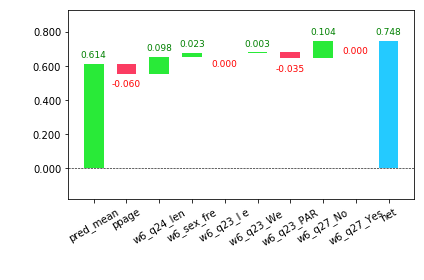

In [93]:
vlist1 = ['ppage', 
          'w6_q24_length', 
          'w6_sex_frequency', 
          'w6_q23_I earned more', 
          'w6_q23_We earned about the same amount', 
          'w6_q23_PARTNER earned more',
          'w6_q23_PARTNER was not working for pay',
          'w6_q27_No',
          'w6_q27_Yes']

VA_plot(xgb, X, obs, vlist1)

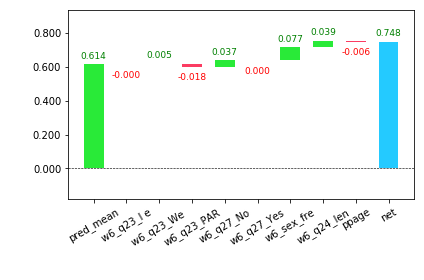

In [95]:
vlist2 = ['w6_q23_I earned more', 
          'w6_q23_We earned about the same amount', 
          'w6_q23_PARTNER earned more',
          'w6_q23_PARTNER was not working for pay',
          'w6_q27_No',
          'w6_q27_Yes',
          'w6_sex_frequency', 
          'w6_q24_length',
          'ppage']

VA_plot(xgb, X, obs, vlist2)

Bardzo ciekawe jest to, że mimo znaczącej zamiany kolejności ustalania poszczególnych zmiennych, odpowiedzi są takie same co do znaku. Przede wszystkim, w obu przypadkach obserwujemy negatywną odpowiedź ze względu na wiek oraz pozytywną ze względu na długość wypowiedzi o poznaniu partnera i częstotliwość uprawiania seksu. Na tej podstawie możemy wnioskować, że te wykresy faktycznie dostarczają pewnych informacji, które nie są zaburzone przez korelacje między zmiennymi.